In [ ]:
'''
ANOVA на сгенерированных данных
'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
np.random.seed(12)

races =   ["asian","black","hispanic","other","white"]

voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups

asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Проводим тест

stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

In [ ]:
'''
Тест дает F-статистику 1,774 и p-value 0,1317, что указывает на отсутствие существенной разницы 
между средними значениями каждой группы.
'''

In [3]:
# Второй способ

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Формула модели
model = ols('age ~ race',                 
            data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df         F    PR(>F)
race        199.369    4.0  1.774469  0.131732
Residual  27948.102  995.0       NaN       NaN


In [ ]:
'''
Создадим новые данные о возрастем различабщимися средними значениями группы.
'''

In [4]:
np.random.seed(12)

voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Длявозрастабелых
white_ages = stats.poisson.rvs(loc=18, 
                              mu=32,
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_age = np.where(voter_race=="white", white_ages, voter_age)

# Групповые данные
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups   

# Данные для отдельных групп
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Применим ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

In [ ]:
'''
Или альтернатива
'''

In [5]:
# Или другим методом
model = ols('age ~ race',                 # Model formula
            data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                sum_sq     df        F        PR(>F)
race       1284.123213    4.0  10.1647  4.561324e-08
Residual  31424.995787  995.0      NaN           NaN


In [ ]:
'''
в этом случае группы не имеют одинаковых выборочных средних, поскольку p-value является значимым при 99%
Мы можем выполнить t-тест между всеми парами через stats.ttest_ind().
'''

In [6]:
race_pairs = []

for race1 in range(4):
    for race2  in range(race1+1,5):
        race_pairs.append((races[race1], races[race2]))

for race1, race2 in race_pairs: 
    print(race1, race2)
    print(stats.ttest_ind(voter_age[groups[race1]], 
                          voter_age[groups[race2]]))

asian black
Ttest_indResult(statistic=0.8386446909747979, pvalue=0.4027281369339345)
asian hispanic
Ttest_indResult(statistic=-0.42594691924932293, pvalue=0.6704669004240726)
asian other
Ttest_indResult(statistic=0.9795284739636, pvalue=0.3298877500095151)
asian white
Ttest_indResult(statistic=-2.318108811252288, pvalue=0.020804701566400217)
black hispanic
Ttest_indResult(statistic=-1.9527839210712925, pvalue=0.05156197171952594)
black other
Ttest_indResult(statistic=0.28025754367057176, pvalue=0.7795770111117659)
black white
Ttest_indResult(statistic=-5.379303881281834, pvalue=1.0394212166624012e-07)
hispanic other
Ttest_indResult(statistic=1.5853626170340225, pvalue=0.11396630528484335)
hispanic white
Ttest_indResult(statistic=-3.5160312714115376, pvalue=0.0004641298649066684)
other white
Ttest_indResult(statistic=-3.763809322077872, pvalue=0.00018490576317593065)


In [ ]:
'''
Однако использование нескорректированных парных t-тестов может привести к переоценке значимости, 
поскольку чем больше сравнений вы сделаете, тем больше вероятность того, что вы встретите маловероятный результат.
Выполним тест Тьюки, используя функцию Pairwise_tukeyhsd() изв библиотеки statsmodels.stats.multicomp.
'''

group1,group2,meandiff,p-adj,lower,upper,reject
asian,black,-0.8032,0.9208,-3.4423,1.836,False
asian,hispanic,0.4143,0.9915,-2.1011,2.9297,False
asian,other,-1.0645,0.8906,-4.2391,2.11,False
asian,white,1.9547,0.1751,-0.4575,4.3668,False
black,hispanic,1.2175,0.2318,-0.386,2.821,False
black,other,-0.2614,0.9986,-2.7757,2.253,False
black,white,2.7579,0.0,1.3217,4.194,True
hispanic,other,-1.4789,0.4374,-3.863,0.9053,False
hispanic,white,1.5404,0.004,0.3468,2.734,True
other,white,3.0192,0.0028,0.7443,5.2941,True


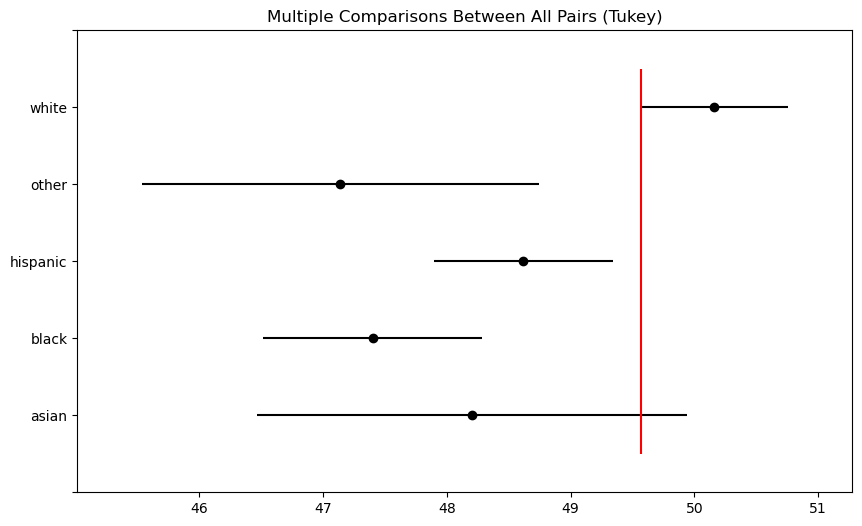

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age,    
                          groups=voter_race,   
                          alpha=0.05)          

tukey.plot_simultaneous()   
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary() 

In [ ]:
'''
Результаты теста Тьюки показывают среднюю разницу, доверительный интервал, а также следует ли вам отклонить нулевую гипотезу
для каждой пары групп на данном уровне значимости. В этом случае тест предлагает отвергнуть нулевую гипотезу для трех пар, 
каждая из которых включает категорию «белые». Это говорит о том, что белая группа, вероятно, отличается от других. 
График доверительного интервала 95% визуально подтверждает результаты: доверительный интервал только одной другой 
группы перекрывает доверительный интервал белой группы.

Тест ANOVA позволяет нам проверить, меняется ли числовая переменная ответа в зависимости от уровней категориальной переменной. 
Библиотека Scipy позволяет легко выполнять ANOVA, не углубляясь в детали процедуры.
'''